In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, TimeDistributed
import matplotlib.pyplot as plt

path = "../../dane/8CPU_20RAM/3600s/few_merged.csv"

In [2]:
# Załaduj dane
df = pd.read_csv(path)

In [3]:
df = pd.get_dummies(df, columns=['endpointUrl_methods'])

In [4]:
boolean_columns = [col for col in df.columns if 'endpointUrl_methods' in col]
df[boolean_columns] = df[boolean_columns].astype(float)

In [5]:
df[['cpuUsage_stock']]

,cpuUsage_stock
0,0.445614
1,0.445649
2,0.445649
3,0.445609
4,0.445649
...,...
2879374,0.217462
2879375,0.217434
2879376,0.217434
2879377,0.217462


In [6]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
# df[['cpuUsage_stock']] = scaler1.fit_transform(df[['cpuUsage_stock']])
df[['memoryUsage_stock']] = scaler1.fit_transform(df[['memoryUsage_stock']])
df[['timestamp']] = scaler3.fit_transform(df[['timestamp']])


In [7]:
# Kodowanie pudełek
le = LabelEncoder()
df['test'] = le.fit_transform(df['test'])

In [8]:
# Filtracja wierszy gdzie test = 0
df_filtered = df.loc[df['test'] == 0]

# Usunięcie kolumny "test"
df_filtered = df_filtered.drop('test', axis=1)


In [9]:
# Wybranie tylko tych kolumn, które są potrzebne
features = df_filtered[[col for col in df.columns if 'endpointUrl_methods' in col]]
targets = df_filtered[[ 'cpuUsage_stock', 'memoryUsage_stock']]
targets = df_filtered[[ 'cpuUsage_stock']]


In [10]:
window_size = 1000  # Rozmiar okna
smoothed_data = targets['cpuUsage_stock'].rolling(window_size, min_periods=1).mean()

# Tworzenie nowego DataFrame z wygładzonymi danymi
df_smoothed = df_filtered.copy()
df_smoothed['cpuUsage_stock'] = smoothed_data

In [11]:
targets = df_smoothed[[ 'cpuUsage_stock']]

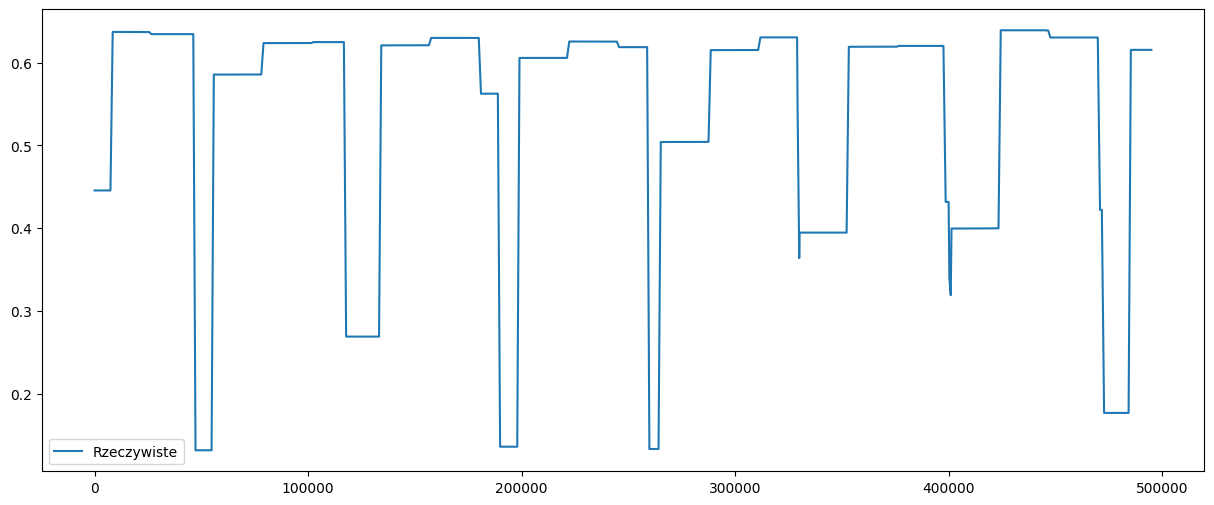

In [12]:
# Wykresy
plt.figure(figsize=(15, 6))
plt.plot(targets, label='Rzeczywiste')
plt.legend()
plt.show()

In [13]:
targets

,cpuUsage_stock
0,0.445614
1,0.445631
2,0.445637
3,0.445630
4,0.445634
...,...
494924,0.615448
494925,0.615448
494926,0.615448
494927,0.615448


In [14]:
# Przygotowanie danych
X = features.values
y = targets.values

In [15]:
# Przygotowanie danych
X = features.values
y = targets.values

# Przewidywanie tylko jednej zmiennej
X = X.reshape((X.shape[0], X.shape[1], 1))

# Podział na zbiór treningowy i testowy
split_index = int(len(X) * 0.5)  # 80% for training, 20% for testing

# # Split the data into training and test sets
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

# Budowanie modelu
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [16]:
# split_index = int(len(X) * 0.5)  # 80% for training, 20% for testing

# # Split the data into training and test sets
# X_train = X[:split_index]
# y_train = y[:split_index]
# X_test = X[split_index:]
# y_test = y[split_index:]

In [17]:
# X_train = X_train.astype(np.float32)
# y_train = y_train.astype(np.float32)

In [18]:
# Zmiana kształtu danych do formatu akceptowanego przez LSTM ([samples, time steps, features])
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [19]:
# X_train = X_train.astype(np.float32)
# y_train = y_train.astype(np.float32)
# X_test = X_test.astype(np.float32)
# y_test = y_test.astype(np.float32)

In [20]:
# # Budowanie modelu
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')

In [21]:
# Trenowanie modelu
history = model.fit(X_train, y_train, epochs=5, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/5
3437/3437 - 18s - loss: 0.0016 - val_loss: 0.0255 - 18s/epoch - 5ms/step
Epoch 2/5
3437/3437 - 14s - loss: 0.0019 - val_loss: 0.0262 - 14s/epoch - 4ms/step
Epoch 3/5
3437/3437 - 14s - loss: 0.0023 - val_loss: 0.0273 - 14s/epoch - 4ms/step
Epoch 4/5
3437/3437 - 15s - loss: 0.0026 - val_loss: 0.0261 - 15s/epoch - 4ms/step
Epoch 5/5
3437/3437 - 15s - loss: 0.0038 - val_loss: 0.0260 - 15s/epoch - 4ms/step


In [22]:
# Przewidywanie
y_pred = model.predict(X_test)

7734/7734 [==============================] - 11s 1ms/step


In [23]:
y_org = scaler1.inverse_transform(y_test)

In [24]:
y_pred

array([[0.6191538],
       [0.6331848],
       [0.6191538],
       ...,
       [0.6191538],
       [0.618502 ],
       [0.6191538]], dtype=float32)

In [25]:
y_pred_org = scaler1.inverse_transform(y_pred)

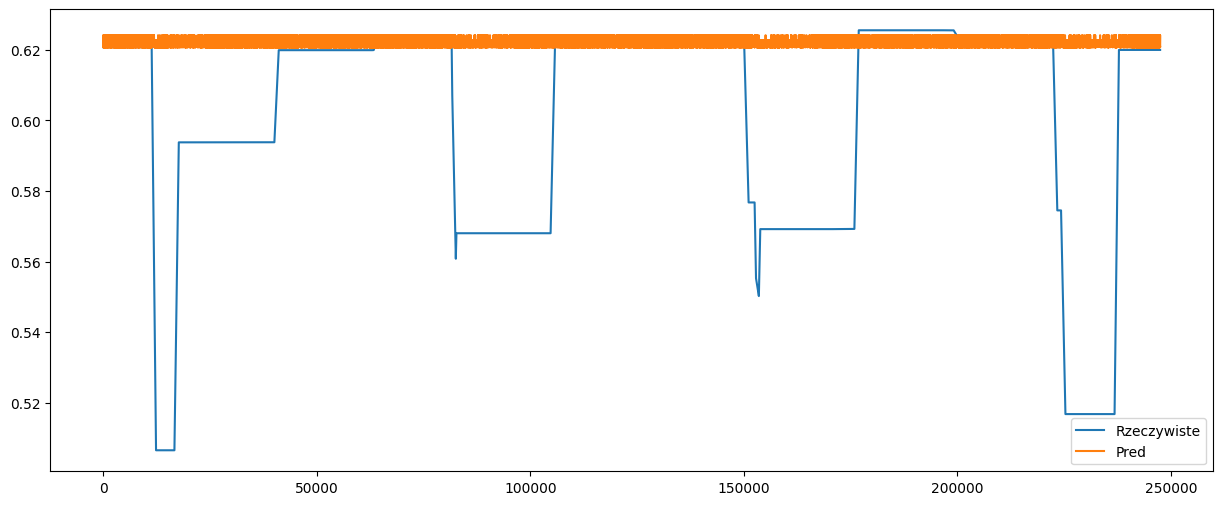

In [27]:
# Wykresy
plt.figure(figsize=(15, 6))
plt.plot(y_org, label='Rzeczywiste')
plt.plot(y_pred_org, label='Pred')
plt.legend()
plt.show()